In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image libraries
import cv2

In [2]:
tf.keras.__version__

'2.10.0'

In [3]:
# directories
# train_img_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
# test_img_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

train_img_path = 'artifact/train'
test_img_path = 'artifact/test'

w,h = 200,200
batch_size = 32

train_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)
test_data_gen = ImageDataGenerator(rescale = 1.0/255)

train_Dataset = train_data_gen.flow_from_directory(
    train_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_Dataset = test_data_gen.flow_from_directory(
    test_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 882752 images belonging to 2 classes.
Found 220694 images belonging to 2 classes.


In [4]:
train_Dataset.class_indices

{'FAKE': 0, 'REAL': 1}

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# CNN Model

In [6]:
# Define the model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(w, h, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Optional dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with 1 neuron (binary classification)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

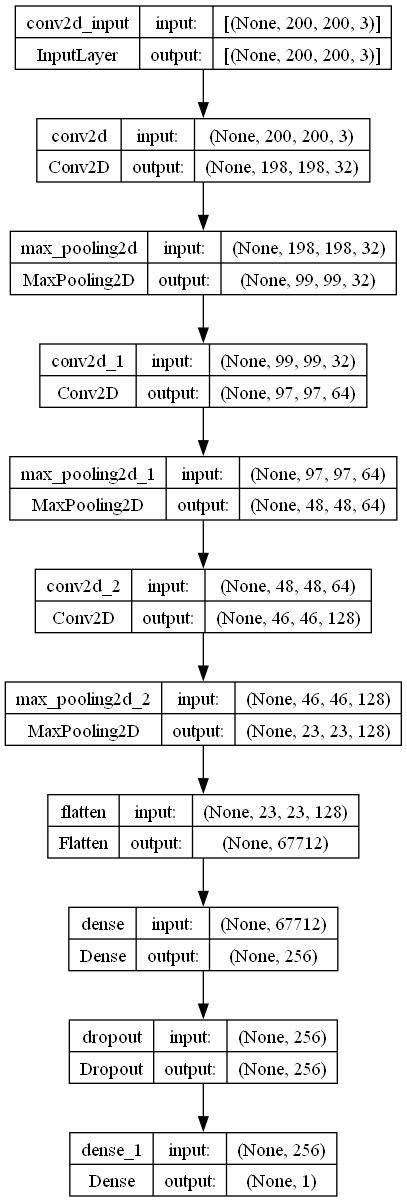

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)


# Run Model



In [8]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
history = model.fit(train_Dataset, 
                    epochs=10, 
#                     callbacks=[model_checkpoint]
                   )

Epoch 1/10
27586/27586 [==============================] - 3091s 112ms/step - loss: 0.5559 - accuracy: 0.6909
Epoch 2/10
27586/27586 [==============================] - 1463s 53ms/step - loss: 0.5146 - accuracy: 0.7242
Epoch 3/10
27586/27586 [==============================] - 1431s 52ms/step - loss: 0.4972 - accuracy: 0.7368
Epoch 4/10
27586/27586 [==============================] - 1180s 43ms/step - loss: 0.4873 - accuracy: 0.7436
Epoch 5/10
27586/27586 [==============================] - 1127s 41ms/step - loss: 0.4799 - accuracy: 0.7476
Epoch 6/10
27586/27586 [==============================] - 1013s 37ms/step - loss: 0.4762 - accuracy: 0.7506
Epoch 7/10
27586/27586 [==============================] - 932s 34ms/step - loss: 0.4733 - accuracy: 0.7530
Epoch 8/10
27586/27586 [==============================] - 916s 33ms/step - loss: 0.4705 - accuracy: 0.7542
Epoch 9/10
27586/27586 [==============================] - 949s 34ms/step - loss: 0.4695 - accuracy: 0.7557
Epoch 10/10
27586/27586 [=====

In [10]:
model.save_weights('./checkpoints/my_checkpoint_200')

In [11]:
model.save('my_model_200.keras')


In [12]:
model.save('my_model_200.h5')


In [13]:
# load best weights to model
# model.load_weights(weight_path)

# make prediction
predictions = model.predict(test_Dataset)
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

6897/6897 [==============================] - 781s 113ms/step


array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [14]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_Dataset.classes, binary_predictions)
print(f'Accuracy: {accuracy*100:.2f}%')


Accuracy: 75.10%


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have true labels (ground truth)
true_labels = test_Dataset.classes

# Generate a confusion matrix
# sns.heatmap(confusion_matrix(true_labels, binary_predictions), annot=True)

# Print classification report
print(classification_report(true_labels, binary_predictions))

# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual Classes')
# plt.show()

              precision    recall  f1-score   support

           0       0.73      0.63      0.68     90962
           1       0.76      0.84      0.80    129732

    accuracy                           0.75    220694
   macro avg       0.75      0.73      0.74    220694
weighted avg       0.75      0.75      0.75    220694

